# Classifying Names with a Character Level RNN

In this tutorial we try to predict the nationality of a name by processing it through a bidirectional LSTM one character at a time. We have 18 input files, each corresponding to a different nationality. We will store the names in a dictionary of the form `{'Nationality': [name1, name2, ...], ...}`. The [`glob` module](https://docs.python.org/3/library/glob.html) is more convenient than `os.listdir` for this purpsose, as it returns the full path.

In [1]:
# from io import open
import os
import glob
import string
from functools import reduce
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

%matplotlib inline

file_list = glob.glob('../data/names/*.txt')
print(file_list)

['../data/names/German.txt', '../data/names/Arabic.txt', '../data/names/Vietnamese.txt', '../data/names/Dutch.txt', '../data/names/Polish.txt', '../data/names/Portuguese.txt', '../data/names/Scottish.txt', '../data/names/Korean.txt', '../data/names/Irish.txt', '../data/names/Russian.txt', '../data/names/Czech.txt', '../data/names/Greek.txt', '../data/names/Italian.txt', '../data/names/Spanish.txt', '../data/names/French.txt', '../data/names/Japanese.txt', '../data/names/English.txt', '../data/names/Chinese.txt']


Let's create the dictionary:

In [2]:
category_lines = {}

for file_name in file_list:
    nationality = os.path.basename(os.path.splitext(file_name)[0])
    name_list = []
    for line in open(file_name, 'r'):
        name_list.append(line.rstrip())
    category_lines[nationality] = name_list

print(category_lines['German'][:4])
print(category_lines.keys())

['Abbing', 'Abel', 'Abeln', 'Abt']
dict_keys(['German', 'Arabic', 'Vietnamese', 'Dutch', 'Polish', 'Portuguese', 'Scottish', 'Korean', 'Irish', 'Russian', 'Czech', 'Greek', 'Italian', 'Spanish', 'French', 'Japanese', 'English', 'Chinese'])


Some of the names contain accents and other non-ASCII characters that can make things complicated. We may convert all the characters to plain ASCII, as shown in the vignette, but our task would probably be easier if we could account for the non-ASCII characters. Some characters, for exaample, are specific of Polish, so encountering one of such characters would be already a strong hint that the name is indeed Polish. Let's try this approach, which deviates from the one in the [tutorial](http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html). We read each file in turn, and for each file we extract the set of unique characters.

In [3]:
def get_unique_characters(filename):
    character_sets = []
    for name in open(filename, 'r'):
        character_sets.append(set(name.lower()))
    unique_characters = reduce(set.union, character_sets)
    return unique_characters

Let's try with the first element of `file_list`, which contains the German names.

In [4]:
unique_german = get_unique_characters(file_list[0])
print(unique_german)
print(len(unique_german))

{'d', 'm', 'e', 'q', 's', 'ß', 'h', 'y', 'v', 'b', 'f', 'c', 'z', 'p', 'l', 'j', 'a', 'r', 'k', '\n', 'x', 'ü', 'n', 'u', 'o', 'g', 'ä', 'w', 't', ' ', 'i', 'ö'}
32


Let's run this method on all files:

In [5]:
all_unique_characters = [get_unique_characters(f) for f in file_list]
all_unique_characters = reduce(set.union, all_unique_characters)
print(all_unique_characters)
print(len(all_unique_characters))

{'d', 'e', 'q', 's', 'h', 'y', 'v', 'c', 'z', 'p', 'j', 'é', '\xa0', 'r', 'ê', 'k', '\n', 'x', 'ą', 'n', 'o', 'ì', 'ó', 'w', 'ł', 'á', 't', ' ', "'", 'õ', ':', 'm', '/', 'í', 'ß', 'ú', 'b', 'f', 'ã', 'ñ', 'l', 'ż', 'a', '1', 'ś', ',', 'è', 'ü', '-', 'u', 'g', 'ä', 'ù', 'i', 'ö', 'à', 'ò', 'ń', 'ç'}
59


This gives us all the characters appearing in the files. We can turn this into a dictionary to later create one-hot encodings of the individual characters.

In [6]:
character_dict = {char: ix for ix, char in enumerate(all_unique_characters)}
print(character_dict)

{'d': 0, 'e': 1, 'q': 2, 's': 3, 'h': 4, 'y': 5, 'v': 6, 'c': 7, 'z': 8, 'p': 9, 'j': 10, 'é': 11, '\xa0': 12, 'r': 13, 'ê': 14, 'k': 15, '\n': 16, 'x': 17, 'ą': 18, 'n': 19, 'o': 20, 'ì': 21, 'ó': 22, 'w': 23, 'ł': 24, 'á': 25, 't': 26, ' ': 27, "'": 28, 'õ': 29, ':': 30, 'm': 31, '/': 32, 'í': 33, 'ß': 34, 'ú': 35, 'b': 36, 'f': 37, 'ã': 38, 'ñ': 39, 'l': 40, 'ż': 41, 'a': 42, '1': 43, 'ś': 44, ',': 45, 'è': 46, 'ü': 47, '-': 48, 'u': 49, 'g': 50, 'ä': 51, 'ù': 52, 'i': 53, 'ö': 54, 'à': 55, 'ò': 56, 'ń': 57, 'ç': 58}


In order to build a name classifier we need to turn the names into character tensors. In our dictionary there are 59 characters, so each name should be represented as a tensor of shape $(l_n, 1, 59)$, where $l_n$ is the length of the name.

In [7]:
def name_to_tensor(name, dictionary=character_dict):
    len_name = len(name)
    len_dictionary = len(dictionary)
    output = torch.zeros(len_name, len_dictionary)
    for k in range(len_name):
        output[k, dictionary[name[k]]] = 1
    output = output.view(len_name, 1, len_dictionary)
    return Variable(output)

Let's see if this function returns something sensible. We test on a fake surname consisting of the first three keys in the dictionary.

In [8]:
name_to_tensor('v x')

Variable containing:
(0 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 38 to 56 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 57 to 58 
    0   0

(1 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0

Columns 38 to 56 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 57 to 58 
    0   0

(2 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 38 to 56 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 57 t

Now we need to encode the nationality into a long tensor.

In [9]:
nationality_dict = {nationality: ix for ix, nationality in enumerate(category_lines.keys())}

def nationality_to_tensor(nationality, dictionary=nationality_dict):
    nationality_tensor = torch.LongTensor([dictionary[nationality]])
    return Variable(nationality_tensor)

As before, let's check if this works. The first key is 'German', so the first element of the output should be a 1.

In [10]:
print(nationality_dict)
nationality_to_tensor('German')

{'German': 0, 'Arabic': 1, 'Vietnamese': 2, 'Dutch': 3, 'Polish': 4, 'Portuguese': 5, 'Scottish': 6, 'Korean': 7, 'Irish': 8, 'Russian': 9, 'Czech': 10, 'Greek': 11, 'Italian': 12, 'Spanish': 13, 'French': 14, 'Japanese': 15, 'English': 16, 'Chinese': 17}


Variable containing:
 0
[torch.LongTensor of size 1]

In the [tutorial](http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) there are slightly different, and probably more efficient implementations, of these functions.

## Model creation

We can now build one or more models to see how well (or badly) we perform on this task. We can start with a simple model with one single LSTM layer. Here we feed the one-hot encoded characters to the LSTM. There are a few things to note in this model:

1. the `hidden_dim` parameter is stored in a class attribute for later use in `init_hidden`.
2. `self.hidden` is initialized by `init_hidden` when we instantiate the class. The object we obtain is therefore already initialized.
3. The `self.lstm_output` tensor still has shape (1, 1, num_nationalities). This is why we need to reshape it.

Finally note that here we are making an experiment. We take the hidden state of the last step of the LSTM, and we feed it into the fully connected layer.

In [11]:
class SimpleLSTM(nn.Module):
    
    def __init__(self, hidden_dim, vocabulary_size, num_nationalities):
        super(SimpleLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_nationalities = num_nationalities
        self.lstm = nn.LSTM(input_size=vocabulary_size, hidden_size=hidden_dim)
        self.linear = nn.Linear(in_features=hidden_dim, out_features=num_nationalities)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return (Variable(torch.zeros(1, 1, self.hidden_dim)), 
                Variable(torch.zeros(1, 1, self.hidden_dim)))
    
    def forward(self, inputs):
        lstm_output, lstm_hidden = self.lstm(inputs, self.hidden)
        last_output = lstm_output[len(inputs) - 1]
        output = self.linear(last_output)
        output = F.log_softmax(output, dim=1)
        return output

Let's instantiate this class and apply it to one input

In [12]:
HIDDEN_DIM = 8
VOCABULARY_SIZE = len(character_dict)
NUM_NATIONALITIES = len(nationality_dict)

print(HIDDEN_DIM, VOCABULARY_SIZE, NUM_NATIONALITIES)

8 59 18


In [13]:
simple_lstm = SimpleLSTM(HIDDEN_DIM, VOCABULARY_SIZE, NUM_NATIONALITIES)

In [14]:
test_name = name_to_tensor('sierpinsky')
output = simple_lstm(test_name)
output

Variable containing:

Columns 0 to 9 
-2.7548 -3.0228 -2.9007 -2.9889 -3.1759 -2.9469 -3.0174 -2.7576 -2.5518 -2.7996

Columns 10 to 17 
-2.7950 -2.9458 -2.9164 -2.8029 -2.7879 -3.0171 -2.9504 -3.0852
[torch.FloatTensor of size 1x18]

Let's create an optimizer to be applied to the model parameters.

In [15]:
loss_function = nn.NLLLoss()
optimizer = optim.SGD(simple_lstm.parameters(), lr=0.1)

We can now iterate on the inputs and train. We need something that can generate random {name, nationality} pairs. To this end, we create a helper function.

In [16]:
def get_random_pair(input_dictionary):
    nationalities = list(input_dictionary.keys())
    nationality = random.choice(nationalities)
    name = random.choice(input_dictionary[nationality])
    return name_to_tensor(name.lower()), nationality_to_tensor(nationality)

We must be careful to turn the output names to lowercase, to avoid problems when converting to a tensor, as the character dictionary doesn't comprise uppercase characters.

In [17]:
test_name, test_nationality = get_random_pair(category_lines)
print(test_name.size())
print(test_nationality.size())
print(type(test_name), type(test_nationality))

torch.Size([5, 1, 59])
torch.Size([1])
<class 'torch.autograd.variable.Variable'> <class 'torch.autograd.variable.Variable'>


In [28]:
NUM_EPOCHS = 30
STEPS_PER_EPOCH = 1000

loss_history = []

k = 0
for epoch in range(NUM_EPOCHS):
    print('Epoch: {}'.format(epoch))
    for step in range(STEPS_PER_EPOCH):
        simple_lstm.zero_grad()
        simple_lstm.hidden = simple_lstm.init_hidden()
        input, target = get_random_pair(category_lines)
        output_scores = simple_lstm(input)
        loss = loss_function(output_scores, target)
        if k % 100 == 0:
            loss_history.append(loss.data.numpy()[0])
        loss.backward()
        optimizer.step()
        k += 1

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


Let's check that the loss has actually decreased during training.

[1.4345362, 0.45775518, 2.278161, 4.8217554, 2.387222, 2.4770122, 0.15617909, 1.6518058, 0.24032326, 0.0059923823, 0.51312333, 1.8279037, 0.734622, 0.24847049, 0.8013752, 3.178698, 0.082784995, 0.4086973, 1.7454914, 1.4621563, 1.5288228, 2.8329573, 1.7850094, 0.5976076, 2.2369452, 0.13403773, 0.15101944, 0.028004328, 2.571294, 0.5246396, 0.16596869, 2.5890825, 0.5323, 2.4483232, 0.98805803, 0.031101838, 0.033280198, 0.24636875, 1.1190886, 0.3713911, 0.015798736, 1.1042222, 0.41999847, 1.6976091, 2.6918552, 1.7196851, 1.3576381, 2.7320142, 0.83970755, 0.0047142114, 1.4361687, 0.8265884, 4.3237934, 0.4301912, 4.7381263, 4.207761, 2.449709, 2.2202866, 1.8369769, 3.0114343, 1.0969951, 1.109471, 0.9334187, 1.5463387, 1.1602281, 5.619881, 3.4947484, 0.39471126, 0.035193734, 4.226609, 0.61533755, 2.5438633, 0.4348335, 0.7458245, 0.2050372, 0.009121669, 0.63466704, 2.1136425, 0.3441364, 1.0071946, 0.78750646, 0.8561999, 1.9728681, 0.33702397, 0.07361834, 0.16518246, 0.0023275404, 1.3618143, 2.

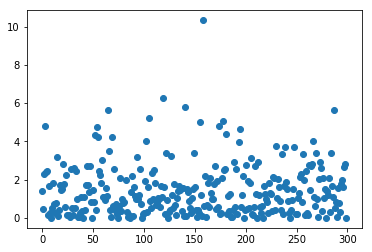

In [33]:
print(loss_history)
plt.plot(range(len(loss_history)), loss_history, 'o')

Let's see a prediction on the trained model. We revert the nationality dictionary and create a utility function that prints the output indexes.

In [ ]:
ix_to_nationality = {ix: nationality for nationality, ix in nationality_dict.items()}

def print_predicted_classes(name, k=3):
    name = name_to_tensor(name)
    class_score = simple_lstm(name)
    val, idx = class_score.topk(k, 1)
    idx = idx.data.numpy().flatten()
    for i in idx:
        print(ix_to_nationality[i])

In [ ]:
print_predicted_classes('ferrauto')

In [ ]:
print_predicted_classes('van der waals')

In [ ]:
print_predicted_classes('soares')

In [ ]:
print_predicted_classes('yamamoto')

In [ ]:
print_predicted_classes('dermitzakis')

In [ ]:
print_predicted_classes('messner')